In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import savgol_filter
from moxie.data.utils_ import load_data, standardize, de_standardize, normalize_profiles

In [2]:
# boilerplate stuff
import math
from collections.abc import Iterable

class RunningStats:
    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0

    def push(self, x):
        if isinstance(x, Iterable):
            for v in x:
                self.push(v)
            return

        self.n += 1

        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = self.old_m + (x - self.old_m) / self.n
            self.new_s = self.old_s + (x - self.old_m) * (x - self.new_m)

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0

    def standard_deviation(self):
        return math.sqrt(self.variance())

    def __repr__(self):
        return f'n: {self.n}, mean: {self.mean()}, var: {self.variance()}, sd: {self.standard_deviation()}'
    
def standardize_signal(x, trim_zeros=True):
    if trim_zeros:
        x_in = np.trim_zeros(x)
    else:
        x_in = x
    rs = RunningStats() # numpy.std goes to inf so do it by hand
    rs.push(x_in)
    return (x - rs.mean()) / rs.standard_deviation()

In [4]:
train_data, val_data, test_data = load_data(dataset_choice='SANDBOX_NO_VARIATIONS', file_loc='../../../moxie/data/processed/pedestal_profiles_ML_READY_ak_5052022_uncerts_mask.pickle', elm_timings=False)
(train_X, train_y, train_mask, train_radii, train_real_space_radii, train_ids, train_uncert), (val_X, val_y, val_mask, val_radii, val_real_space_radii, val_ids, val_uncert), (test_X, test_y, test_mask, test_radii, test_real_space_radii, test_ids, test_uncert) = train_data, val_data, test_data


81768/49.22


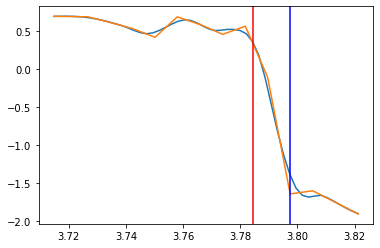

3.7843079566955566 3.797351360321045
81795/54.12


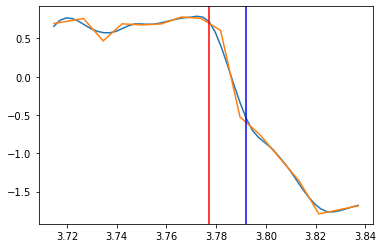

3.7771365934488723 3.792115829428848
81810/54.77


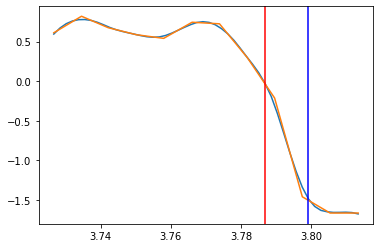

3.7868220416867002 3.7992052983264535
81826/53.42


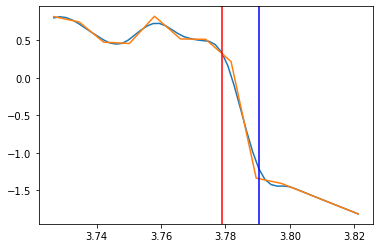

3.778783861471682 3.7903657202817955
81837/53.97


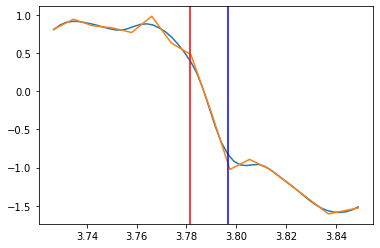

3.781587333095317 3.7965668610164096
81980/54.17


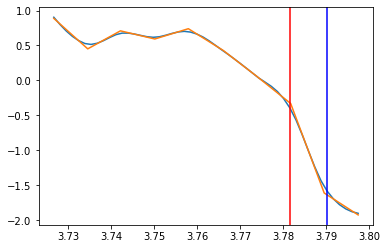

3.7815524509974887 3.7902211461748396
82122/50.07


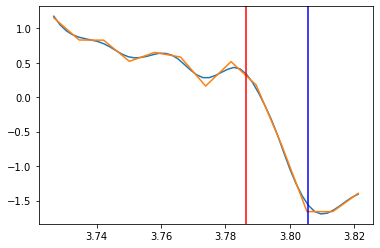

3.7864968874016585 3.8058011045261306
82129/49.82


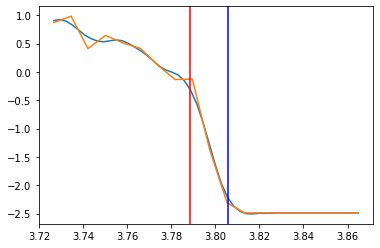

3.7886879638749726 3.8056085790906633
82140/55.42


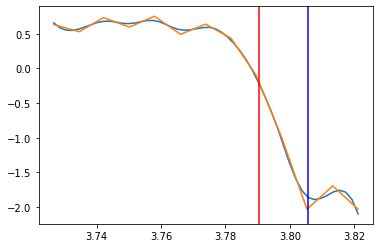

3.7903528359471537 3.805796988156377
82193/50.47


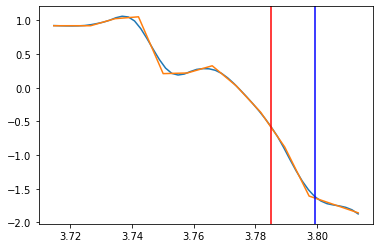

3.7851425920213972 3.7992336409432546


In [31]:
def pedestal_top(p_old, x, plot_result=False):
        # standardize signal
        p = standardize_signal(p_old, trim_zeros=True)
        
        # interp signal to Nx=50
        f_interp = interpolate.interp1d(x, p)
        x_h = np.linspace(x[0], x[-1], 50)  # interpolate to 50 (evenly spaced) points
        p_h = f_interp(x_h)

        # smooth with savgol filter
        p_s = savgol_filter(p_h, window_length=11, polyorder=3)

        # get max gradient so we're in the pedestal
        p_s_grad = np.gradient(p_s)
        min_i = np.argmin(p_s_grad)
        
        
        # search from pedestal region outward in 2nd derivatives
        p_s_grad2 = np.gradient(p_s_grad)
        p_s_grad2 = savgol_filter(p_s_grad2, window_length=11, polyorder=3)  # aggressively smooth as well
        p_s_grad2 = standardize_signal(p_s_grad2, trim_zeros=True)
        # standardize s.t. if we go >1 sd up/down, we stop searching
        
        # go to the left from middle point
        sd_cutoff = -.5
        start_cut_early = False  # if we go < -1 for x'', mark as such, such that if we go > -1 again we stop looking
        min_val = p_s_grad2[min_i]
        top_i = min_i
        for i in reversed(range(0, min_i)):
            if p_s_grad2[i] < min_val:
                min_val = p_s_grad2[i]
                top_i = i
                if min_val < sd_cutoff:
                    start_cut_early = True
            elif start_cut_early and p_s_grad2[i] > sd_cutoff:
                break
        
        # found our x for top
        # same procedure for bottom
        sd_cutoff = .5
        start_cut_early = False  # if we go > 1 for x'', etc.
        max_val = p_s_grad2[min_i]
        bottom_i = min_i
        
        for i in range(min_i+1, x_h.shape[0]):
            if p_s_grad2[i] > max_val:
                max_val = p_s_grad2[i]
                bottom_i = i
                if max_val > sd_cutoff:
                    start_cut_early = True
            elif start_cut_early and p_s_grad2[i] < sd_cutoff:
                break
        
        top, bottom = x_h[top_i], x_h[bottom_i]
        top_left_one = x_h[top_i - 1]
        
        if plot_result:
            plt.plot(x_h, p_s)
            plt.plot(x, p)
            plt.axvline(top, color='red')
            plt.axvline(bottom, color='blue')
            plt.show()
        return top, bottom

# grab example data
for i in range(10):
    idx = i*100
    print(train_ids[idx])
    mask = train_mask[i] > 0
    # x = train_radii[i][mask]
    x = train_real_space_radii[i][mask]
    ne = train_X[idx][0][mask]
    # te = dataset['all_dict']['raw']['profiles'][idx][0]
    
    top_x, bottom_x = pedestal_top(ne, x, plot_result=True)
    print(top_x, bottom_x)
